In [2]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.constants import epsilon as epsilon_const
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load data and average over `sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import ds, get_P

ds = ds['aquaplanet']
p_ft = ds.p_ft
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds['lapse_Dz'] = ds.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.modParc1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']

In [137]:
n_quant = 21
temp_surf_ref_change = 5
temp_surf_anom = np.linspace(-10, 10, n_quant)  # max anom of 5K in the current climate
rh_quant_anom = np.linspace(-0.2, 0.2, n_quant)  # max anom of 20% in current climate
rh_quant_change = np.linspace(-0.02, 0.02, n_quant) * temp_surf_ref_change  # max change of 2% per Kelvin
temp_ft_quant_change = np.linspace(0.5, 2, n_quant) * temp_surf_ref_change  # max change of 2K per Kelvin, min of 0.5K per Kelvin
p_surf_quant_anom = np.linspace(-200, 200, n_quant) * 100  # max anom of 200hPa in current climate
p_surf_quant_change = np.linspace(-10, 10, n_quant) * 100 * temp_surf_ref_change  # max change of 10hPa per Kelvin
lapse_D_quant = np.linspace(-10, 10, n_quant)  # max anom in the current climate of 10K (around 1K/km)
lapse_D_quant_change = np.linspace(-1, 1,
                                   n_quant) * temp_surf_ref_change  # max change of 1K per Kelvin (around 0.1K/km per Kelvin)
lapse_M_quant = np.linspace(-10, 10, n_quant)
lapse_M_quant_change = np.linspace(-1, 1, n_quant) * temp_surf_ref_change

sf_var = {'temp_surf_ref': np.array([300, 300 + temp_surf_ref_change]),
          'rh_ref': 0.5, 'p_ft': 500 * 100,
          'p_surf_ref': 1000 * 100, 'temp_surf_lcl_calc': 300, 'lapse_coords': 'lnp'
          }

sf_var['rh_quant'] = sf_var['rh_ref'] + np.vstack([rh_quant_anom, rh_quant_anom + rh_quant_change])
sf_var['p_surf_quant'] = sf_var['p_surf_ref'] + np.vstack([p_surf_quant_anom, p_surf_quant_anom + p_surf_quant_change])
sf_var['lapse_D_quant'] = np.vstack([lapse_D_quant, lapse_D_quant + lapse_D_quant_change])
sf_var['lapse_M_quant'] = np.vstack([lapse_M_quant, lapse_M_quant + lapse_M_quant_change])

In [138]:
def get_temp(rh, p_surf, lapse_D=0, lapse_M=0, sCAPE=None, temp_surf=None, temp_ft=None):
    # Has useful default values as ref in cold climate. So to find effect of a mechanism, just
    # change that variable.
    # Still gives option to compute surf or FT temp
    if sCAPE is not None:
        lapse_D = 0
        lapse_M = 0
        R_mod = R / 2 * np.log(p_surf / sf_var['p_ft'])
        temp_ft_dev = sCAPE / R_mod  # Value of T_ft_parc - T_ft_env given formula for sCAPE
        if temp_surf is None:
            # When finding surface temperature, use parcel temperature at FT, then follow parcel profile to surface
            # with lapse_D = 0; lapse_M=0.
            temp_ft = temp_ft + temp_ft_dev

    temp_sol = get_temp_mod_parcel(rh, p_surf, sf_var['p_ft'], lapse_D, lapse_M, temp_surf, temp_ft,
                                   lapse_coords='lnp',
                                   temp_surf_lcl_calc=sf_var['temp_surf_lcl_calc'])
    if (sCAPE is not None) and (temp_surf is not None):
        # In this case, will have computed the parcel temperature at the FT
        # Get environmental temperature from parcel by subtracting (T_ft_parc - T_ft_env)
        temp_sol = temp_sol - temp_ft_dev
    return temp_sol


get_temp = np.vectorize(get_temp)

In [139]:
# Compute temperatures using mod_parcel formulae
temp_surf_quant0 = sf_var['temp_surf_ref'][0] + temp_surf_anom  # Know temp_surf_quant in base climate
# Compute temp_ft_quant in base climate from all other parameters
temp_ft_quant0 = get_temp(sf_var['rh_quant'][0], sf_var['p_surf_quant'][0], sf_var['lapse_D_quant'][0],
                          sf_var['lapse_M_quant'][0], temp_surf=temp_surf_quant0)
# Know change in temp_ft with warming so know temp_ft in both climates
sf_var['temp_ft_quant'] = np.vstack([temp_ft_quant0, temp_ft_quant0 + temp_ft_quant_change])
# Given temp_ft and all other variables in warm climate, compute temp_surf in warm climate
temp_surf_quant1 = get_temp(sf_var['rh_quant'][1], sf_var['p_surf_quant'][1], sf_var['lapse_D_quant'][1],
                            sf_var['lapse_M_quant'][1], temp_ft=sf_var['temp_ft_quant'][1])
sf_var['temp_surf_quant'] = np.vstack([temp_surf_quant0, temp_surf_quant1])

In [140]:
ds.T_ft_env.mean(dim='sample').diff(dim='tau_lw').min()

<xarray.DataArray 'T_ft_env' ()> Size: 8B
array(5.05297852)
Coordinates:
    surf     <U10 40B 'aquaplanet'

In [141]:
sf_cont = get_scale_factor_theory_numerical2(**sf_var)[3]

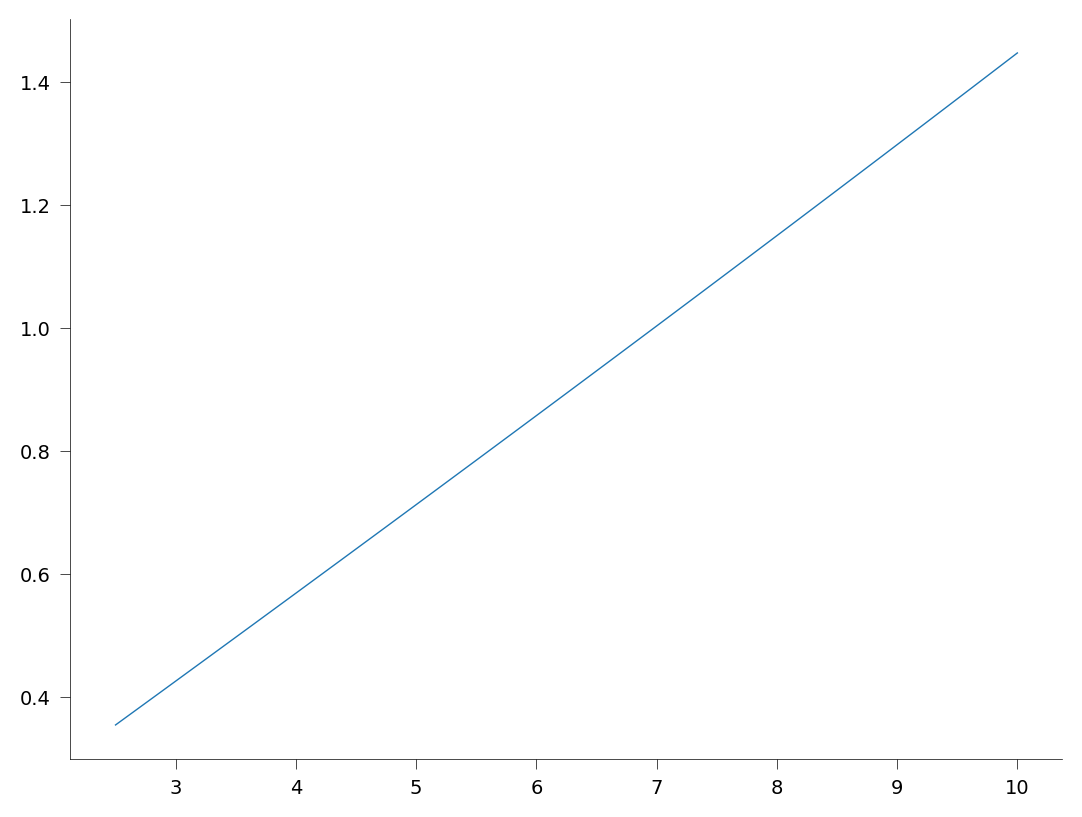

In [144]:
plt.plot(temp_ft_quant_change, sf_cont['temp_ft_change'])

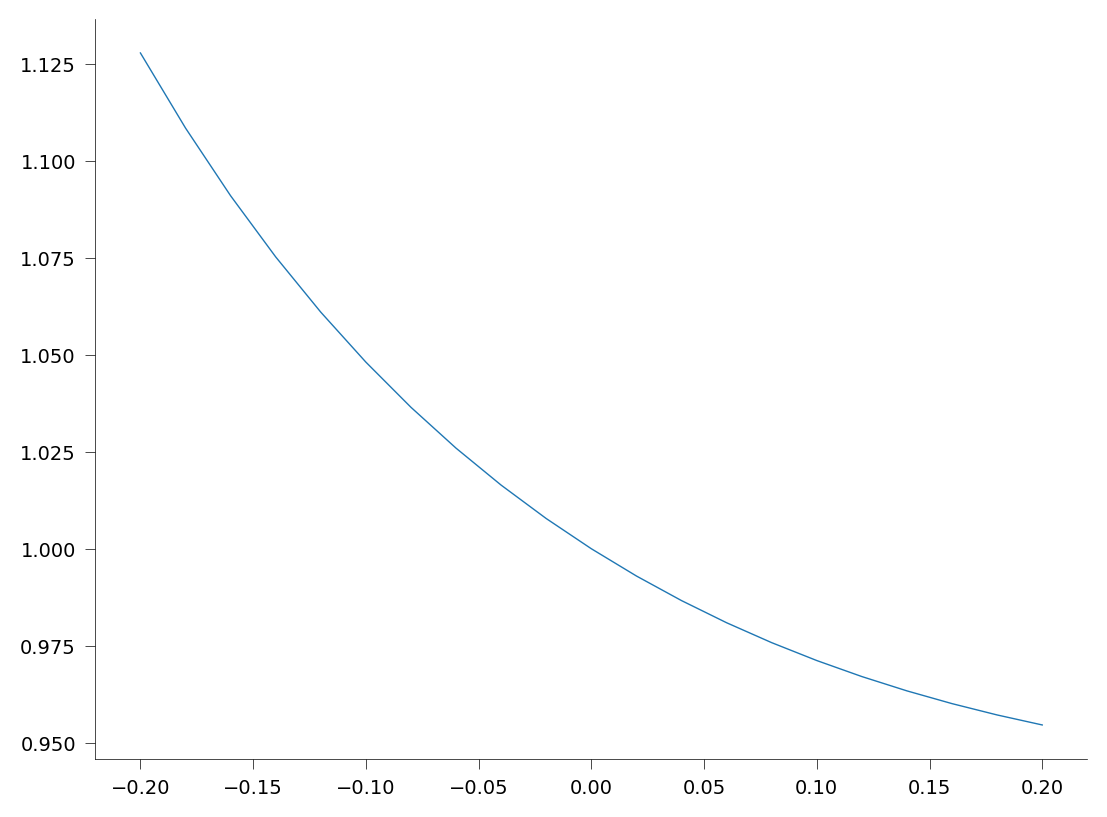

In [122]:
plt.plot(rh_quant_anom, sf_cont['rh_anom'])

In [87]:
ds.lapse_M.mean(dim='sample').max()

<xarray.DataArray 'lapse_M' ()> Size: 8B
array(4.52059126)
Coordinates:
    surf     <U10 40B 'aquaplanet'

In [5]:
# Take average over all days for which error satisfies convective threshold
error_thresh = 0.25
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(
    ds.modParc1_error.sum(dim='layer') / ds.modParc1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)

# Get rid of variables don't need anymore - those with lev and layer dimensions
ds = ds.drop_dims(['lev', 'layer'])

# ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
# Reference is computed from all days
ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
# For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
ds_quant = ds.where(mask_fit).mean(dim='sample')
# ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall

In [6]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat')
ds_ref = ds_ref.transpose('tau_lw', 'lat')

In [7]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'
colors_cont = {'T_ft_env': 'C2',
               'TREFHT': 'C3',
               'rh_REFHT': 'C0',
               'lapse_Mz': 'C1', 'lapse_Mz_error': 'C1',
               'lapse_Dz': 'C4', 'lapse_Dz_error': 'C4',
               'PREFHT': 'C6',
               'epsilon_av_error': 'C6',
               'epsilon_nl_error': 'C5'}

label_cont = {'T_ft_env': '$T_{FT}$', 'TREFHT': '$T_s$', 'rh_REFHT': '$r_s$', 'PREFHT': '$p_s$',
              'lapse_Mz': '$\eta_{Mz}$', 'lapse_Mz_error': '$A_{\eta_M}$',
              'lapse_Dz': '$\eta_{Dz}$', 'lapse_Dz_error': '$A_{\eta_D}$',
              'epsilon_av_error': '$A_{\epsilon \\text{av}}$',
              'epsilon_nl_error': '$A_{\epsilon \\text{NL}}$', }

In [8]:
def sphum_sat_approx(temp, pressure):
    return epsilon_const * saturation_vapor_pressure(temp) / pressure


(sphum_sat(300, 1000 * 100) - sphum_sat_approx(300, 1000 * 100)) / sphum_sat(300, 1000 * 100) * 100

1.3361479980183602

In [9]:
sphum_sat_approx = saturation_vapor_pressure(300) / (1000 * 100)

In [10]:
def get_p_surf_mse_effect(p_surf_anom=100 * 100, p_surf_ref=1000 * 100, r_surf_ref=1, temp_surf_ref=300):
    R_mod_anom = R / 2 * (np.log(p_surf_ref + p_surf_anom) - np.log(p_surf_ref))
    sphum_sat_anom = sphum_sat(temp_surf_ref, p_surf_ref + p_surf_anom) - sphum_sat(temp_surf_ref, p_surf_ref)
    # sphum_sat_anom = -sphum_sat(temp_surf_ref, p_surf_ref)/p_surf_ref * p_surf_anom
    mse_cont_R = R_mod_anom * temp_surf_ref
    mse_cont_sphum_sat = sphum_sat_anom * L_v * r_surf_ref
    return mse_cont_R / 1000, mse_cont_sphum_sat / 1000


get_p_surf_mse_effect()

(4.103675101654969, -5.126228537192679)

## Theory for Parcel - Environment $T$
Requires conversion to $\ln(p)$ coordinate lapse rate parameters.

If we convert the lapse rate adjustmenet parameters into logp coordinates through $\eta_D = \frac{RT_s}{g}\eta_{Dz}$ and $\eta_M = \frac{RT_{FT}}{g}\eta_{Mz}$, then the theoretical estimates for the terms required for the scaling factor become a lot simpler with no climatological $\eta_M$ term:

$$
\begin{array}{rl}
\delta T_{FT\text{parc}}[x] - \delta T_{FT}[x] &\approx& \ln \left(\frac{p_s\tilde{r}_s^{\nu}}{p_{FT}}\right) \delta \eta_M[x] \\
\delta T_{s\text{parc}}[x] - \delta T_s(x) &\approx&
\ln \left(\tilde{r}_s^{\nu}\right) \delta \eta_D[x] \\
\Delta T_{s\text{parc}}[x] - \Delta T_s[x] &\approx&
\ln \left(\tilde{r}_s^{\nu}\right) \Delta \eta_D[x]
\end{array}
$$

These approximations are shown below.

In [11]:
def get_temp_parcel(temp_surf, temp_ft, rh_surf, p_surf, lapse_Dz, lapse_Mz, p_ft=p_ft,
                    temp_lcl_ref=temp_surf_lcl_calc):
    sigma_lcl = lcl_sigma_bolton_simple(rh_surf, temp_lcl_ref)
    sigma_ft = p_ft / p_surf
    exponent_use = R * lapse_Mz / g
    temp_ft_parcel = temp_ft * sigma_lcl ** exponent_use * sigma_ft ** (-exponent_use)
    exponent_use = R * lapse_Dz / g
    temp_surf_parcel = temp_surf * sigma_lcl ** exponent_use
    return temp_surf_parcel, temp_ft_parcel


def get_temp_ft_parcel_change_theory(rh_ref, lapse_M_quant_change,
                                     rh_quant_change, lapse_M_quant,
                                     p_surf, p_ft=p_ft, temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \delta T_FTparc[x] - \delta T_FT[x]
    # Need lapse_M in logp coordinates
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    exponent = np.log(sigma_lcl) / np.log(rh_ref)
    cont = {}
    cont['$\delta \eta_M[x]$'] = np.log(sigma_lcl * p_surf / p_ft) * lapse_M_quant_change
    cont['$\eta_M[x] \delta r_s[x]$'] = lapse_M_quant * exponent * rh_quant_change / rh_ref
    cont['$\delta \eta_M[x] \delta r_s[x]$'] = lapse_M_quant_change * exponent * rh_quant_change / rh_ref
    var_sum = sum(cont[k] for k in cont)
    return var_sum, cont


def get_temp_surf_parcel_change_theory(rh_ref, lapse_D_quant_change,
                                       rh_quant_change, lapse_D_quant, temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \delta T_sparc[x] - \delta T_s[x]
    # Need lapse_D in logp coordinates
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    exponent = np.log(sigma_lcl) / np.log(rh_ref)
    cont = {}
    cont['$\delta \eta_D[x]$'] = np.log(sigma_lcl) * lapse_D_quant_change
    cont['$\eta_D[x] \delta r_s[x]$'] = lapse_D_quant * exponent * rh_quant_change / rh_ref
    cont['$\delta \eta_D[x] \delta r_s[x]$'] = lapse_D_quant_change * exponent * rh_quant_change / rh_ref
    var_sum = sum(cont[k] for k in cont)
    return var_sum, cont


def get_temp_surf_parcel_anom_theory(rh_ref, lapse_D_quant, rh_quant, lapse_D_ref=0,
                                     temp_lcl_ref=temp_surf_lcl_calc):
    # Returns approximation to \Delta T_sparc[x] - \Delta T_s[x]
    # Need lapse_D in logp coordinates
    sigma_lcl = lcl_sigma_bolton_simple(rh_ref, temp_lcl_ref)
    exponent = np.log(sigma_lcl) / np.log(rh_ref)
    cont = {}
    cont['$\Delta \eta_D[x]$'] = np.log(sigma_lcl) * (lapse_D_quant - lapse_D_ref)
    cont['$\Delta \eta_D[x] \Delta r_s[x]$'] = exponent * (lapse_D_quant - lapse_D_ref) * (rh_quant - rh_ref) / rh_ref
    var_sum = sum(cont[k] for k in cont)
    return var_sum, cont

In [12]:
temp_surf_parcel, temp_ft_parcel = get_temp_parcel(ds_quant.TREFHT, ds_quant.T_ft_env, ds_quant.rh_REFHT,
                                                   ds_quant.PREFHT,
                                                   ds_quant.lapse_Dz, ds_quant.lapse_Mz)

var, temp_ft_parcel_change_cont = get_temp_ft_parcel_change_theory(
    ds_ref.rh_REFHT.isel(tau_lw=0), ds_quant.lapse_M.diff(dim='tau_lw').squeeze(),
    ds_quant.rh_REFHT.diff(dim='tau_lw').squeeze(), ds_quant.lapse_M.isel(tau_lw=0), ds_quant.PREFHT.isel(tau_lw=1))
temp_ft_parcel_change_cont['$A_{\delta T_{FT\\text{parc}}}$'] = \
    temp_ft_parcel.diff(dim='tau_lw').squeeze() - ds_quant.T_ft_env.diff(dim='tau_lw').squeeze() - var

var, temp_surf_parcel_change_cont = get_temp_surf_parcel_change_theory(
    ds_ref.rh_REFHT.isel(tau_lw=0), ds_quant.lapse_D.diff(dim='tau_lw').squeeze(),
    rh_quant_change=ds_quant.rh_REFHT.diff(dim='tau_lw').squeeze(),
    lapse_D_quant=ds_quant.lapse_D.isel(tau_lw=0))
temp_surf_parcel_change_cont['$A_{\delta T_{s\\text{parc}}}$'] = \
    temp_surf_parcel.diff(dim='tau_lw').squeeze() - ds_quant.TREFHT.diff(dim='tau_lw').squeeze() - var

var, temp_surf_parcel_anom_theory_cont = get_temp_surf_parcel_anom_theory(
    ds_ref.rh_REFHT.isel(tau_lw=0), ds_quant.lapse_D.isel(tau_lw=0), ds_quant.rh_REFHT.isel(tau_lw=0), 0)
temp_surf_parcel_anom_theory_cont['$\Delta A_{\eta_{Dz}}[x]$'] = \
    (temp_surf_parcel - ds_ref.TREFHT).isel(tau_lw=0) - (ds_quant.TREFHT - ds_ref.TREFHT).isel(tau_lw=0) - var

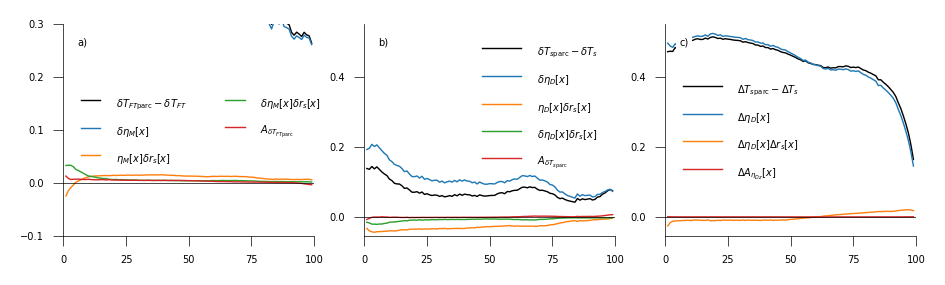

In [13]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])

# ax.plot(ds_quant.quant, np.average(temp_ft_parcel.diff(dim='tau_lw').squeeze() -
#                                    ds_quant.T_ft_env.diff(dim='tau_lw').squeeze(), weights=lat_weights, axis=1),
#         color='C2', label='$\delta T_{FT\\text{parc}} - \delta T_{FT}$')
# ax.plot(ds_quant.quant, np.average(temp_ft_parcel_change_theory, weights=lat_weights, axis=0), color='C2',
#         linestyle=':')

ax[0].plot(ds_quant.quant, np.average(temp_ft_parcel.diff(dim='tau_lw').squeeze() -
                                      ds_quant.T_ft_env.diff(dim='tau_lw').squeeze(), weights=lat_weights, axis=1),
           color='k', label='$\delta T_{FT\\text{parc}} - \delta T_{FT}$')
for i, key in enumerate(temp_ft_parcel_change_cont):
    ax[0].plot(ds_quant.quant,
               np.average(temp_ft_parcel_change_cont[key].transpose('quant', 'lat'), weights=lat_weights, axis=1),
               color=f"C{i}", label=key)

ax[1].plot(ds_quant.quant, np.average(temp_surf_parcel.diff(dim='tau_lw').squeeze() -
                                      ds_quant.TREFHT.diff(dim='tau_lw').squeeze(), weights=lat_weights, axis=1),
           color='k', label='$\delta T_{s\\text{parc}} - \delta T_s$')
for i, key in enumerate(temp_surf_parcel_change_cont):
    ax[1].plot(ds_quant.quant,
               np.average(temp_surf_parcel_change_cont[key].transpose('quant', 'lat'), weights=lat_weights, axis=1),
               color=f"C{i}", label=key)

ax[2].plot(ds_quant.quant, np.average((temp_surf_parcel - ds_ref.TREFHT).isel(tau_lw=0) -
                                      (ds_quant.TREFHT - ds_ref.TREFHT).isel(tau_lw=0), weights=lat_weights, axis=1),
           color='k', label='$\Delta T_{s\\text{parc}} - \Delta T_s$')
for i, key in enumerate(temp_surf_parcel_anom_theory_cont):
    ax[2].plot(ds_quant.quant,
               np.average(temp_surf_parcel_anom_theory_cont[key].transpose('quant', 'lat'), weights=lat_weights,
                          axis=1),
               color='C3' if 'A' in key else f"C{i}", label=key)

# ax.plot(ds_quant.quant, np.average(temp_surf_parcel_change_theory, weights=lat_weights, axis=0), color='C0',
#         linestyle=':')
#
# # ax.plot(ds_quant.quant, np.average((temp_surf_parcel - ds_ref.TREFHT).isel(tau_lw=0) -
# #                                    (ds_quant.TREFHT - ds_ref.TREFHT).isel(tau_lw=0), weights=lat_weights, axis=1),
# #         color='C1', label='$\Delta T_{s\\text{parc}} - \Delta T_s$')
# # ax.plot(ds_quant.quant, np.average(temp_surf_parcel_anom_theory, weights=lat_weights, axis=0), color='C1',
# #         linestyle=':')
#
# ax.plot(-10, -10, color='k', label='Simulated')
# ax.plot(-10, -10, color='k', linestyle=':', label='Theory')
#
update_linewidth(fig)
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
# ax.set_ylabel('Parc - Env [K]')
# ax.set_xlabel(percentile_label)
ax[1].sharey(ax[2])
ax[0].set_xlim(0, 100)
# ax.set_ylim(0, 2.5)
# ax.legend(ncol=2, handlelength=1.3)
label_subplots(fig, ax)
ax[0].legend(handlelength=1, ncol=2)
ax[1].legend()
ax[2].legend()
ax[0].set_ylim(-0.1, 0.3)
update_fontsize(fig, 7)
plt.show()
# isca_tools.savefig(fig)

### Numerical scaling factor

In [14]:
def apply_scale_factor(ds_quant, ds_ref, p_ft=p_ft, lapse_coords='lnp'):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"],  # (tau_lw)
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        ds_quant[f"lapse_D{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw, quant)
        ds_quant[f"lapse_M{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"],  # (tau_lw) or scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_ref[f"lapse_D{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw) or None
        ds_ref[f"lapse_M{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw) or None
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc,
            lapse_coords=lapse_coords
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw"],
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            ["tau_lw"],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw"],
            ["tau_lw"],
        ],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [15]:
def apply_scale_factor2(ds_quant, ds_ref, p_ft=p_ft, lapse_coords='lnp'):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_nl, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical2,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"].isel(tau_lw=0),
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"].isel(tau_lw=0),  # scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_quant[f"lapse_D{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw, quant)
        ds_quant[f"lapse_M{'z' if lapse_coords == 'z' else ''}"],  # (tau_lw, quant)
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc,
            lapse_coords=lapse_coords,
            sCAPE_quant=None
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            [],  # rh_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            [],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            ["tau_lw", "quant"]],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            ["quant"],
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_nl": out_nl,
                         "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [24]:
# ds_sf_num = apply_scale_factor(ds_quant, ds_ref, p_ft, 'lnp')
ds_sf_num2 = apply_scale_factor2(ds_quant, ds_ref, p_ft, 'lnp')

In [23]:
ds_sf_num = ds_sf_num2

In [18]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C4", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C4", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--"),
    "scale_factor_nl": ('k', "--"),
}

In [20]:
names = [v for v in ds_sf_num.data_vars if ('nl_' in v and 'residual' not in v and 'error' not in v and 'sum' not in v)]

ds_sf_num["nl_sum"] = (ds_sf_num[names] - 1).to_array(dim="variable").sum("variable") + 1
ds_sf_num["nl_sum2"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1

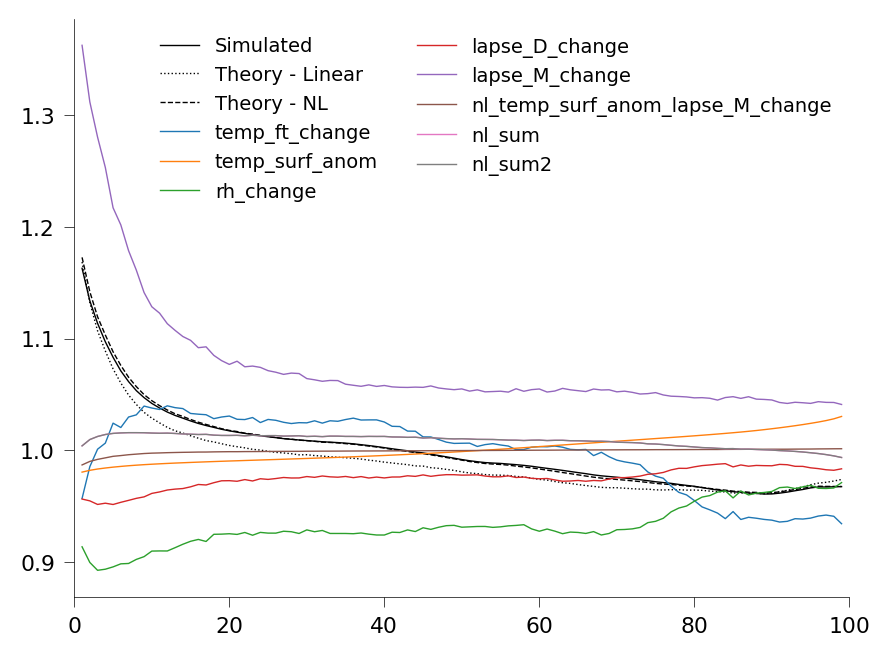

In [21]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for key in ['', '_linear', '_nl']:
    ax.plot(ds_sf_num.quant, np.average(ds_sf_num[f"scale_factor{key}"], axis=0, weights=lat_weights),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label={'': 'Simulated', '_linear': 'Theory - Linear', '_sum': None, '_nl': 'Theory - NL'}[key])
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf_num:
    var = ds_sf_num[key]
    if 'scale_factor' in key:
        continue
    # elif 'nl' in key:
    #     # Combine non-linear and linear into single mechanism on plot
    #     continue
    if np.nanmax(np.average(np.abs(var - 1), axis=0, weights=lat_weights)) < 0.01:
        continue
    # ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key,
    #         color=style_map[key][0], linestyle=style_map[key][1])
    ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key)
# update_linewidth(fig)
# ax.legend(ncol=2)
# ax.axhline(1, color='k', lw=ax_linewidth)
# ax.set_xlabel(percentile_label)
# ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
# ax.set_title(
#     f"{region.capitalize()} | {season.capitalize()} | $(\kappa = {ds_sf.co2.values[1]}) - (\kappa = {ds_sf.co2.values[0]})$ | "
#     f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig, 5)
ax.set_xlim(0, 100)
# ax.set_ylim(0.88, 1.38)
ax.legend(ncol=2)
plt.show()

In [22]:
np.nanmax(np.average(np.abs(var - 1), axis=0, weights=lat_weights))

0.015922700944721493